In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, fbeta_score, make_scorer, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import shap

In [2]:
# Dataset Básico

df = pd.read_csv("/content/drive/MyDrive/Ps Ligia Time 16/risco_cardiovascular_base.csv")

## Dados iguais com classes diferentes
df["BMI Category"] = df["BMI Category"].replace("Normal", "Normal Weight")

In [3]:
# Codificação do Target (Separação Features e Target)

X = df.drop("BP_Category", axis=1)
le = LabelEncoder()
y = le.fit_transform(df["BP_Category"])

In [4]:
# Divisão dos conjuntos para Treino e Teste (80/20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Tratamento de Dados

bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]

## Separando features em tipos de dados e transformações necessárias

num_features = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps"]
ord_features = ["BMI Category"]
nom_features = ["Gender", "Occupation"]

preprocessor = ColumnTransformer(transformers=[
    ("numeric", StandardScaler(), num_features),
    ("ordinal", OrdinalEncoder(categories=[bmi_order]), ord_features),
    ("nominal", OneHotEncoder(handle_unknown="ignore"), nom_features)
])

In [6]:
# Estruturação do Pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)), # Define quanto da variânciaexplicada original será mantida para no treinamento
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

In [7]:
#F2-Score (Atribui peso dobrado ao Recall em relação a Precisão)

f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [8]:
# Estruturação dos parâmetros para o GridSearch

param_grid = {
    'xgb__n_estimators': [50, 100, 200], # Quantidade de árvores
    'xgb__max_depth': [3, 4, 5],         # Profundidade (baixa para evitar decorar)
    'xgb__learning_rate': [0.01, 0.1],   # Velocidade de aprendizado
    'xgb__gamma': [0, 0.1, 0.2],         # Custo para criar novos nós (poda)
    'pca__n_components': [5, 7, 9]       # Quantos componentes manter
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=f2_scorer, n_jobs=-1)

In [9]:
# GridSearch encontra a configuração do melhor modelo

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:12:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Sleep '
                                                                          'Duration',
                                                                          'Quality '
                                                                          'of '
                                                                          'Sleep',
                                                                          'Physical '
                                                                          'Activity '
                                                                          'Level',
                                                                          'Stress '
                                                                          'Level',
                                                                          'Heart '
                                                                          'Rate',
                                                                          'Daily '
                                                                          'Steps']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(categories=[['Underweight',
                                                                                                     'Normal '
                                                                                                     'Weight',
                                                                                                     'Overweight',
                                                                                                     'Obese']]),
                                                                         ['BMI '
                                                                          'Category...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [5, 7, 9],
                         'xgb__gamma': [0, 0.1, 0.2],
                         'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 4, 5],
                         'xgb__n_estimators': [50, 100, 200]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2, average=weighted))

In [10]:
# Avaliação do modelo

print(f"\n---RELATÓRIO DE CLASSIFICAÇÃO---")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# 1. Relatório por classe
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 2. Média de amostragem de todas as classes (AUC-ROC)
auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
print(f"\nAUC-ROC Global: {auc_score:.4f}")

# 3. F2-Score
f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')
print(f"\nF2-Score Decisivo: {f2:.4f}")

# 4. Melhores Hiperparâmetros encontrados
print("\nMelhores parâmetros:", grid_search.best_params_)


---RELATÓRIO DE CLASSIFICAÇÃO---
                     precision    recall  f1-score   support

           Elevated       0.96      1.00      0.98        22
Hypertension_Stage1       1.00      1.00      1.00        20
             Normal       1.00      0.97      0.98        33

           accuracy                           0.99        75
          macro avg       0.99      0.99      0.99        75
       weighted avg       0.99      0.99      0.99        75


AUC-ROC Global: 1.0000

F2-Score Decisivo: 0.9866

Melhores parâmetros: {'pca__n_components': 9, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 200}


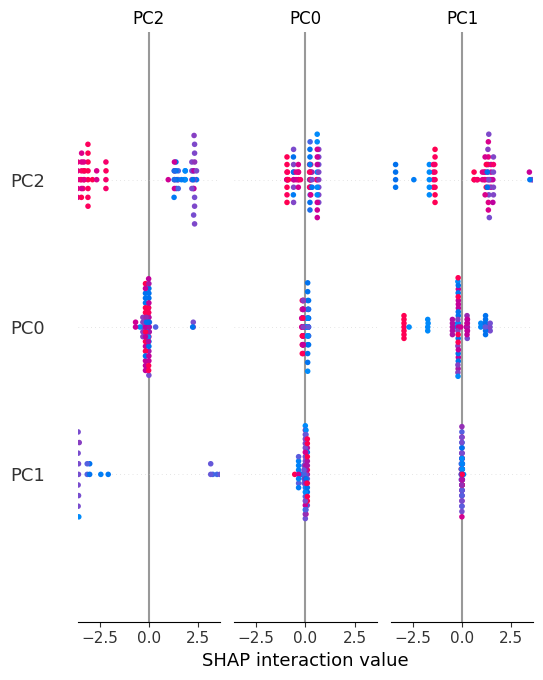

In [14]:
# Visualização de impacto das features nos resultados (utilizando SHAP)

xgb_model = best_model.named_steps["xgb"]

## Aplicar transformações no conjunto de teste
data_transformer = Pipeline(steps=[
    ("preprocessor", best_model.named_steps["preprocessor"]),
    ("pca", best_model.named_steps["pca"])
])

X_test_transformed = data_transformer.transform(X_test)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

## Gráfico do resultado da "força" das features na previsão do modelo
shap.summary_plot(shap_values, X_test_transformed,
                  feature_names=[f"PC{i}" for i in range(X_test_transformed.shape[1])])

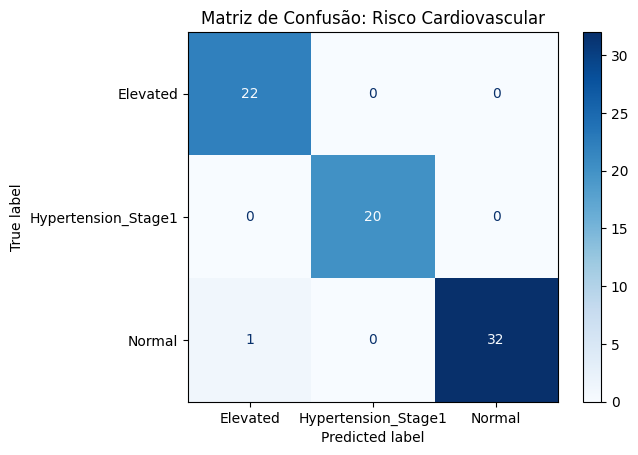

In [17]:
# Matriz de Confusão (Visualização da precisão e recall do modelo)

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão: Risco Cardiovascular')
plt.show()